# Features

My pipline is:
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* merge shops/items/cats to the matrix
* get monthly sales/orders for each item/shop pair in the train set and merge it to the matrix
* get monthly avg price for each item in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* add mean encoded features to the matrix
* merge shops/items/cats to the test set, add date_block_num column = 34
* concatinate matrix and test
* fill nans for 34 month with zeros
* add month feature
* foreach item/shop pair count number of months from the last sale
* create data by adding lag features for the [0,1,2,3,4,5,12]th months to the matrix
* fill nans
* cut first year and drop columns which can not be calculated for the test set
* save matrix to the the file

TODO:
* add TF-IDF features
* create sales and returns columns based on item_cnt_day. sales for > 0 and returns for < 0. then aggregate both and use them as target values (item_sales_cnt_month and item_returns_cnt_month). build two models one for sales and another for returns. merge their predictions as a sum. I supose that predict returns is more easy and another model without returns probably will behave like withour noise. For example if no items were sold in the past means no items will be returned in the future.
* create separate model for the shop=12 which is online shop.
* try to classify items by is_digital property somehow. digital items should have zero sales on the phisical shops.
* try to classify items by is_service property somehow. service is like delivery or repairment.
* try to exclude items from test which are not present in the full train and predict zeros for them manualy
* use regularization with mean encoding

Does not work:
* delta_price and constant_price feature
* is_online, is_mall for shops
* item_last_sale
* item_price as lag feature

In [1]:
import numpy as np
import pandas as pd
import time
import sys
import pickle

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

sys.version_info

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)

## Data

In [2]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv.gz', compression='gzip')
# I set index to avoid removing ID column later
test  = pd.read_csv('test.csv.gz', compression='gzip').set_index('ID') 

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

C:\Anaconda\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


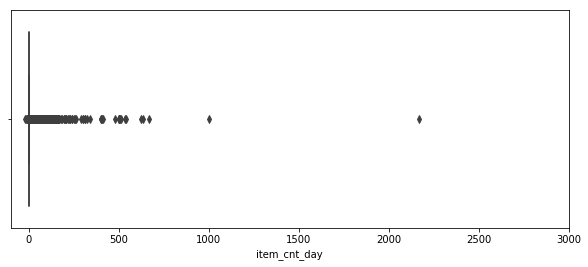

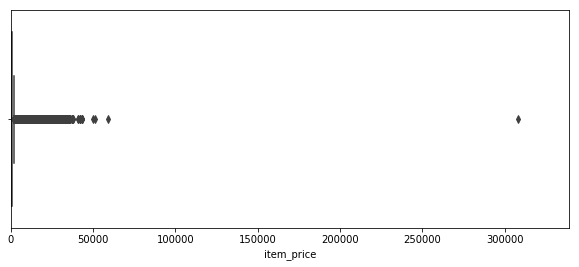

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [4]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with the price below zero. Fill it with median.

In [5]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [6]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [7]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Test set is a product of some shops and items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.

I also tried other strategies
* instead of monthly product use full time product of date_block_num, train.shop_id and test.shop_id, train.item_id and test.shop_id. I supose this way mean encodings wokrs better but the final matrix is to huge for my PC.
* append test.item_id and test.shop_id to each month product

In [8]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [9]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

35.20312428474426

Merge matrix with shops items and cats. I always check and downcast column types to increase the perfomance.

In [10]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

17.57356071472168

I decided to aggregate train set by shop/item pairs to calculate sales sum and count and also by item only to calculate avg item price (it allows to avoid nulls). I use these properties as targets when apply mean encodings.

<b>NB</b> I use floats instead of ints for item_cnt_month and orders to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.

In [11]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({
    'item_cnt_day': ['sum', 'count']
})
group.columns = ['item_cnt_month', 'orders']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip trget here
                                .astype(np.float16))
matrix['orders'] = matrix['orders'].fillna(0).astype(np.float16)
time.time() - ts

18.938607215881348

In [12]:
ts = time.time()
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['item_price'] = matrix['item_price'].astype(np.float32) 
time.time() - ts

10.863346576690674

In [13]:
matrix.isnull().any()

date_block_num      False
shop_id             False
item_id             False
city_code           False
item_category_id    False
type_code           False
subtype_code        False
item_cnt_month      False
orders              False
item_price          False
dtype: bool

## Mean encoded features

In [14]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['sum'],
    'item_price': ['mean']
})
group.columns = [ 'date_item_avg_item_cnt', 'date_item_sum_orders', 'date_item_avg_item_price' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix['date_item_sum_orders'] = matrix['date_item_sum_orders'].astype(np.float16)
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float32)
time.time() - ts

17.648563146591187

In [15]:
ts = time.time()
group = matrix.groupby(['shop_id', 'item_id']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['sum'],
    'item_price': ['mean']
})
group.columns = [ 'shop_item_avg_item_cnt', 'shop_item_sum_orders', 'shop_item_avg_item_price' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id','item_id'], how='left')
matrix['shop_item_avg_item_cnt'] = matrix['shop_item_avg_item_cnt'].astype(np.float16)
matrix['shop_item_sum_orders'] = matrix['shop_item_sum_orders'].astype(np.float16)
matrix['shop_item_avg_item_price'] = matrix['shop_item_avg_item_price'].astype(np.float32)
time.time() - ts

23.18212914466858

In [16]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['sum'],
    'item_price': ['mean']
})
group.columns = [ 'date_shop_avg_item_cnt', 'date_shop_sum_orders', 'date_shop_avg_item_price' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix['date_shop_sum_orders'] = matrix['date_shop_sum_orders'].astype(np.float16)
matrix['date_shop_avg_item_price'] = matrix['date_shop_avg_item_price'].astype(np.float32)
time.time() - ts

16.20641279220581

In [17]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({
    'item_cnt_month': ['mean'],
    'orders': ['sum'],
    'item_price': ['mean']
})
group.columns = [ 'date_cat_avg_item_cnt', 'date_cat_sum_orders', 'date_cat_avg_item_price' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix['date_cat_sum_orders'] = matrix['date_cat_sum_orders'].astype(np.float16)
matrix['date_cat_avg_item_price'] = matrix['date_cat_avg_item_price'].astype(np.float32)
time.time() - ts

19.12748670578003

In [18]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({
    'item_cnt_month': ['mean']
})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id','city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
time.time() - ts

43.74211931228638

In [19]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({
    'item_cnt_month': ['mean']
})
group.columns = [ 'date_shop_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id','type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
time.time() - ts

26.121666193008423

In [20]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({
    'item_cnt_month': ['mean']
})
group.columns = [ 'date_shop_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id','subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
time.time() - ts

28.140718460083008

## Test set
To create lag features add all the item/cat/shop based columns to the test set and concatenate it with the matrix. All computed columns will have NaN values for 34 month. Fill them with zeros.

In [21]:
test['date_block_num'] = 34
test = pd.merge(test, shops, on='shop_id', how='left')
test = pd.merge(test, items, on='item_id', how='left')
test = pd.merge(test, cats, on='item_category_id', how='left')
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test['city_code'] = test['city_code'].astype(np.int8)
test['item_category_id'] = test['item_category_id'].astype(np.int8)
test['type_code'] = test['type_code'].astype(np.int8)
test['subtype_code'] = test['subtype_code'].astype(np.int8)

In [22]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, keys=cols)
matrix.fillna(0, inplace=True)
time.time() - ts

6.425164699554443

## Special features

In [23]:
matrix['month'] = matrix['date_block_num'] % 12 + 1

Count months since last sale for each shop/item pair.
I use programing approach.

Create hash table with key equals to {shop_id,item_id} and value equals date_block_num. Iterate data from the top. Foreach row if {row.shop_id,item_id} is not present in the table, then add to the table and set its value to row.date_blocl_num.
if hash table contains key, then calculate the difference beteween cached value and row.date_block_num.

In [24]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = 999
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.set_value(idx, 'item_shop_last_sale', row.date_block_num - last_date_block_num)
        cache[key] = row.date_block_num         
time.time() - ts

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


3664.5821464061737

## Lag features

Foreach lag create a copy of matrix, shift it by lag value and merge it back to original matrix. Avoid lags for item/shop/cat features and some other columns.

In [25]:
ts = time.time()
def shift(df, month):
    copy = df.drop([
        'city_code',
        'item_category_id',
        'type_code',
        'subtype_code',
        'month',
        'item_shop_last_sale',
        'item_price'
    ], axis=1)
    copy['date_block_num'] += month
    return copy

data = matrix
lags = [1, 2, 3, 4, 5, 12]
for i in lags:
    data = pd.merge(data, shift(matrix, i), on=['date_block_num','shop_id','item_id'], how='left',  suffixes=['', '_'+str(i)])

time.time() - ts

327.41770100593567

Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [26]:
ts = time.time()
data = data[data.date_block_num > 11]
data.drop([
    'orders', 
    'item_price',
    'date_item_avg_item_cnt', 
    'date_item_sum_orders',
    'date_item_avg_item_price', 
    'shop_item_avg_item_cnt',
    'shop_item_sum_orders', 
    'shop_item_avg_item_price',
    'date_shop_avg_item_cnt', 
    'date_shop_sum_orders',
    'date_shop_avg_item_price', 
    'date_cat_avg_item_cnt', 
    'date_cat_sum_orders', 
    'date_cat_avg_item_price', 
    'date_item_city_avg_item_cnt', 
    'date_shop_type_avg_item_cnt',
    'date_shop_subtype_avg_item_cnt'
], axis=1, inplace=True)
time.time() - ts

28.20172357559204

Producing lag features also brings a lot of nulls. Deal with them.

In [27]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if df[col].isnull().any():
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
            if ('orders' in col):
                df[col].fillna(0, inplace=True)
            if ('item_price' in col):
                df[col].fillna(df[col].median(), inplace=True)
    return df

data = fill_na(data)
time.time() - ts

33.659765005111694

## File

In [28]:
data.to_pickle('feature_matrix.pickle')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Columns: 112 entries, city_code to shop_item_sum_orders_12
dtypes: float16(79), float32(24), int16(1), int8(8)
memory usage: 1.7 GB
